1.	User_ID						User ID
2.	Product_ID					Product ID
3.	Gender						Sex of User
4.	Age							Age in bins
5.	Occupation					Occupation (Masked)
6.	City_Category				Category of the City (A,B,C)
7.	Stay_In_Current_City_Years	Number of years stay in current city
8.	Marital_Status				Marital Status
9.	Product_Category_1			Product Category (Masked)
10.	Product_Category_2			Product may belongs to other category also (Masked)
11.	Product_Category_3			Product may belongs to other category also (Masked)
12.	Purchase					Purchase Amount (Target Variable)

<p> its a supervised , regression, batch learning problem
</p>

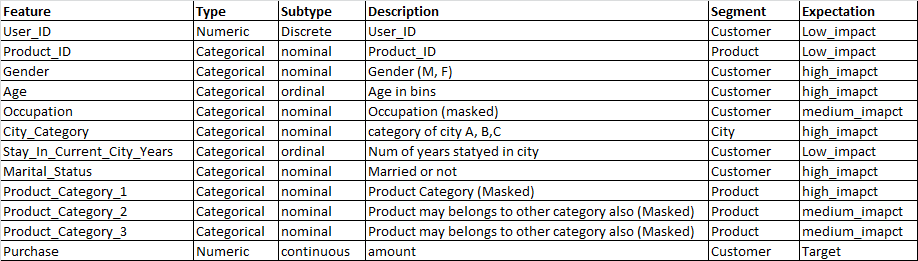

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, PowerTransformer, MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train['User_ID'].nunique()

5891

1. Exploratory data analysis (EDA)
2. Data Pre-processing
3. Feature engineering
4. Feature Transformation
5. Modeling
6. Hyperparameter tuning
7. Ensembling

EDA
1. variable identification
2. univariate analysis
3. bivariate analysis
4. missing value treatment
5. outlier treatment
6. variable transformation
7. variable creation

In [4]:
#1. variable identification
df_varident = train.copy()

In [5]:
df_varident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
#2. univariate analysis --> Frequency distribution, central tendency and dispersion
#frequency distribution:
#numeric cols : hist, box plot
#categoric cols : bar chart
df_uni = df_varident.copy()

In [144]:
num_cols = df_uni.select_dtypes(include=[np.number]).columns
#['User_ID', 'Occupation', 'Marital_Status', 'Product_Category_1','Product_Category_2', 'Product_Category_3', 'Purchase']
#now start analyzing each numerical column

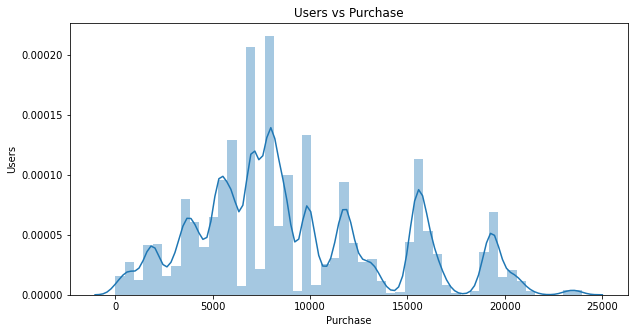

skew : 0.6001400037087128, kurtosis : 0.3383775655851702


count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

In [189]:
#Purchase
plt.figure(figsize=(10,5))
plt.ylabel('Users')
plt.title('Users vs Purchase')
sns.distplot(df_uni['Purchase'])
plt.show()
#its almost guassian (normal distribution)
print('skew : {}, kurtosis : {}'.format(abs(df_uni.Purchase.skew()),abs(df_uni.Purchase.kurtosis())))
# for normal distribution both are 0.
df_uni['Purchase'].describe()

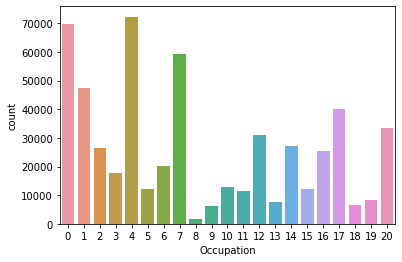

In [194]:
#Occupation
sns.countplot(df_uni.Occupation)

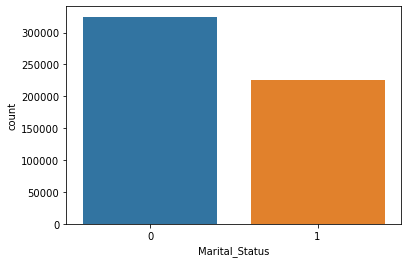

In [195]:
#Marital_Status
sns.countplot(df_uni['Marital_Status'])

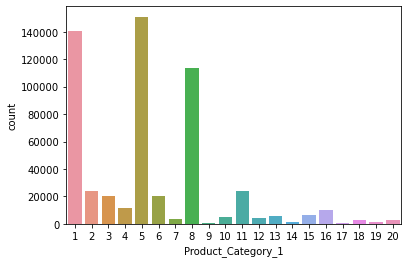

In [184]:
#Product_Category_1
sns.countplot(df_uni['Product_Category_1'])

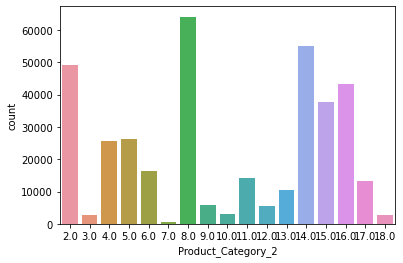

In [185]:
#Product_Category_2
sns.countplot(df_uni['Product_Category_2'])

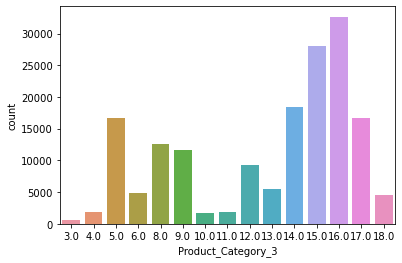

In [186]:
#Product_Category_3
sns.countplot(df_uni['Product_Category_3'])

In [305]:
#bivariate analysis
#continuous vs continuous : scatter plot and correlation
#continuous vs categorical : Z-test, t-test, ANOVA
df_bi = df_uni.copy()

In [199]:
#continuous vs continuous : scatter plot and correlation
corr = df_bi[df_bi.select_dtypes(include=[np.number]).columns].corr()
corr

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023971,0.020443,0.003825,0.001529,0.003419,0.004716
Occupation,-0.023971,1.000000,0.024280,-0.007618,-0.000384,0.013263,0.020833
Marital_Status,0.020443,0.024280,1.000000,0.019888,0.015138,0.019473,-0.000463
Product_Category_1,0.003825,-0.007618,0.019888,1.000000,0.540583,0.229678,-0.343703
Product_Category_2,0.001529,-0.000384,0.015138,0.540583,1.000000,0.543649,-0.209918
Product_Category_3,0.003419,0.013263,0.019473,0.229678,0.543649,1.000000,-0.022006
Purchase,0.004716,0.020833,-0.000463,-0.343703,-0.209918,-0.022006,1.000000


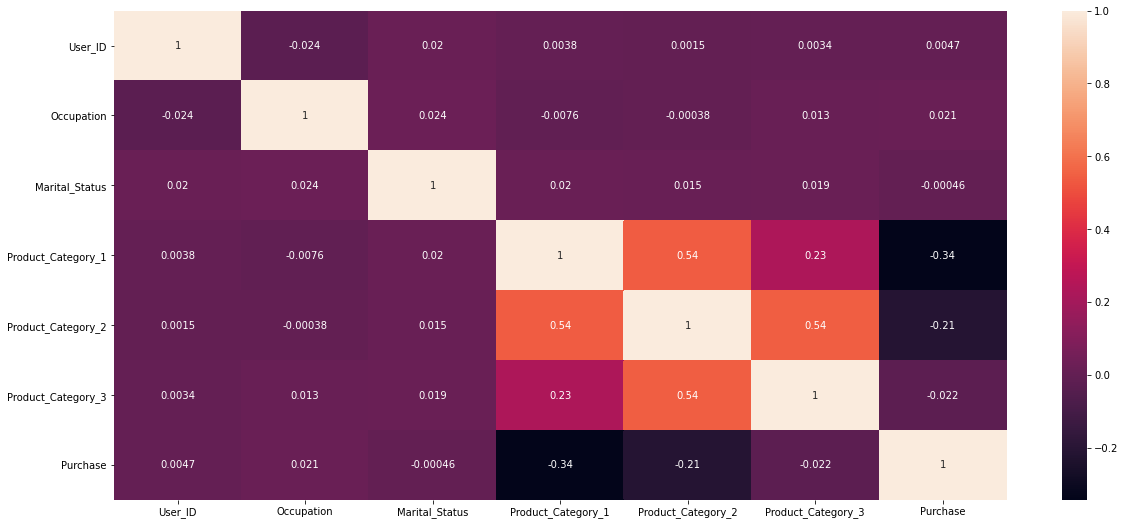

In [205]:
f,ax = plt.subplots(figsize=(20,9))
sns.heatmap(corr,annot=True)
# we can see Purchase has strong +ve correlation with Occupation. its expected.
# And Purchase hase -ve correlation with Product_category_1,2 and 3 also. Since we are not sure about the products for those
# product types , we can not say anything about this.

In [206]:
df_bi.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

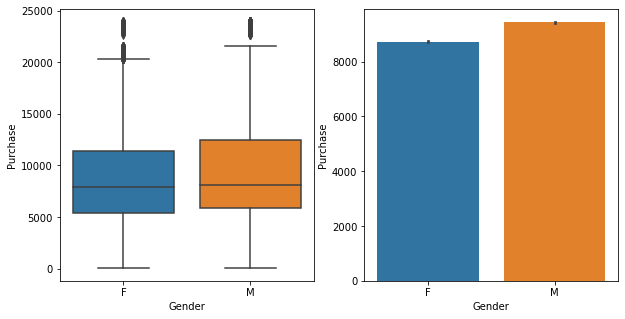

In [266]:
#continuous vs categorical : Z-test, t-test, ANOVA
#Gender vs Purchase
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(df_bi['Gender'],df_bi['Purchase'])
plt.subplot(1,2,2)
sns.barplot(df_bi['Gender'],df_bi['Purchase'])
plt.show()
# male purchase is more and we see some outliers for Purchase 

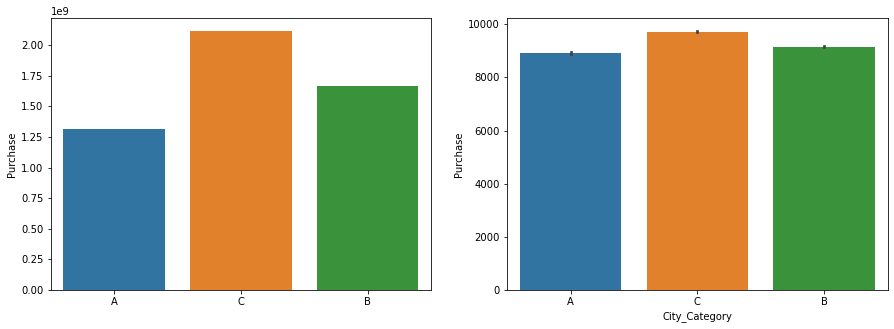

In [369]:
#City_Category vs Purchase
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=df_bi['City_Category'].unique(),y=df_bi.groupby(['City_Category'])['Purchase'].sum() )
plt.subplot(1,2,2)
sns.barplot(x=df_bi['City_Category'],y=df_bi['Purchase'] )
plt.show()
# most of the purchase done city-C and max purchase done in all cities

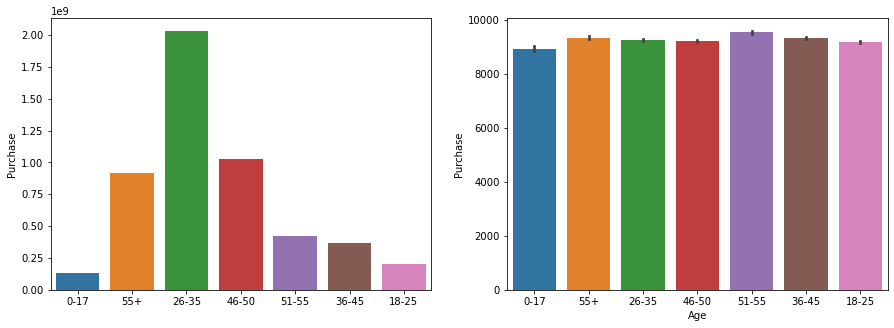

In [370]:
#Age vs Purchase
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=df_bi['Age'].unique(),y=df_bi.groupby(['Age'])['Purchase'].sum() )
plt.subplot(1,2,2)
sns.barplot(x=df_bi['Age'],y=df_bi['Purchase'] )
plt.show()
#most of the purchases done by 26-35 age as expected, but almost all ages spend max purchase

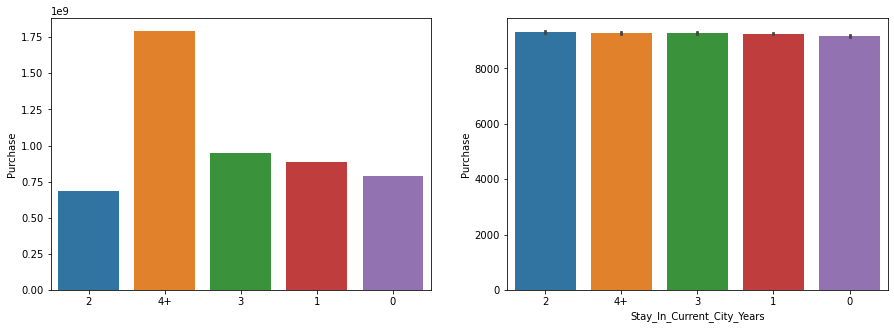

In [372]:
#Stay_In_Current_City_Years vs Purchase
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=df_bi['Stay_In_Current_City_Years'].unique(),y=df_bi.groupby(['Stay_In_Current_City_Years'])['Purchase'].sum() )
plt.subplot(1,2,2)
sns.barplot(x=df_bi['Stay_In_Current_City_Years'],y=df_bi['Purchase'] )
plt.show()
# customer who are staing +4 done most of purchases as expected. 

In [7]:
#Data preprocessing
df_preprocess = train.copy()
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


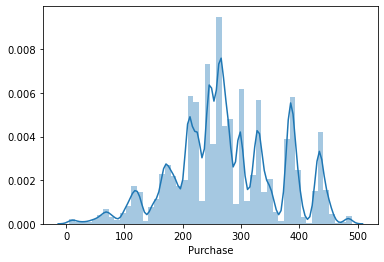

In [15]:
sns.distplot(df_preprocess['Purchase'])

In [10]:
#4. Missing values treatment
df_preprocess.isnull().sum()/df_preprocess.shape[0]*100

8.0

In [19]:
#3. Feature engineering
# we can see Product_Category_2 (31%) and 3(69%) have missing values. 2 approches to follow
# we can use z-test to check the dependency of Purchase with Product_Category_2 and Product_Category_3. So that we can decide
# whether to remove or not. 
# we can impute with mode 
df_preprocess['Product_Category_2'].fillna(df_preprocess['Product_Category_2'].mode()[0],inplace=True)
df_preprocess['Product_Category_3'].fillna(df_preprocess['Product_Category_3'].mode()[0],inplace=True)

In [24]:
# check unique value for each categorical data for encoding
df_preprocess.apply(lambda x : len(x.unique()))

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

In [40]:
#4. Feature transformation
# for frequency count encoding of a feature, we need to check whether any variable has duplicate frequency counts.

#User_ID : it shold be treated as categorical variable. we use frequecy count
#Product_ID : we need to take fequency count
# Gender : lable encoding
# Age : frequency count
# Occupation : frequency count
# City_Category : frequency count
# Stay_In_Current_City_Years : Frequency count
# Marital_Status : label encoding
# Product_Category_1 , Product_Category_2, Product_Category_3 : frequency count

In [ ]:
encode_cols = df_preprocess.columns[1:-1]
for col in encode_cols:
    ser = df_preprocess[col].value_counts()
    print(ser.duplicated())
#except in Proudct_ID we don't have any duplicate counts. so we can use frequency count for all others

In [11]:
freq_count_cols = ['User_ID','Product_ID','Age','Occupation','City_Category','Stay_In_Current_City_Years'
                   ,'Product_Category_1','Product_Category_2','Product_Category_3']
lable_encode_cols = ['Gender','Marital_Status']
#lable encoding
dict_labelencoders = {}
for col in lable_encode_cols:
    encoder = LabelEncoder()
    dict_labelencoders[col] = encoder
    df_preprocess[col]= encoder.fit_transform(df_preprocess[col])
#frequncy count encoding
for col in freq_count_cols:
    df_preprocess[col] = df_preprocess[col].map(df_preprocess[col].value_counts().to_dict() )


In [15]:
df_preprocess.sample(3)
# all look numercial. i think we are ready for model building
#df_preprocess['Stay_In_Current_City_Years'].value_counts().to_dict()
#{193821: 193821, 101838: 101838, 95285: 95285, 84726: 84726, 74398: 74398}

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
26223,439,171,1,38501,33562,231173,193821,1,150933,NaN,NaN,8600
187195,30,29,1,110013,20355,171175,95285,1,113925,NaN,NaN,7819
319461,148,566,1,219587,11586,231173,101838,0,140378,26235.0,28013.0,8245


In [20]:
df_preprocess = df_preprocess.astype('int32')
df_preprocess.info()
df_model = df_preprocess.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   User_ID                     550068 non-null  int32
 1   Product_ID                  550068 non-null  int32
 2   Gender                      550068 non-null  int32
 3   Age                         550068 non-null  int32
 4   Occupation                  550068 non-null  int32
 5   City_Category               550068 non-null  int32
 6   Stay_In_Current_City_Years  550068 non-null  int32
 7   Marital_Status              550068 non-null  int32
 8   Product_Category_1          550068 non-null  int32
 9   Product_Category_2          550068 non-null  int32
 10  Product_Category_3          550068 non-null  int32
 11  Purchase                    550068 non-null  int32
dtypes: int32(12)
memory usage: 25.2 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5108FBA90>,
      dtype=object)

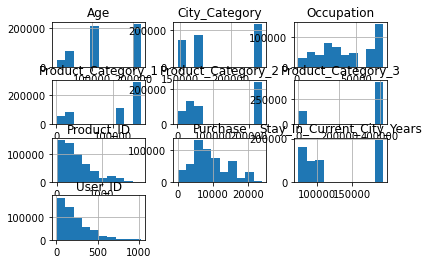

In [61]:
#nothing is in Gaussian
# we need to scale it and make it Gaussian by box cox, except gender and marital_status
tempdf = df_model[[x for x in df_model if x not in ['Gender','Marital_Status']]]
tempdf.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D50F60B780>,
      dtype=object)

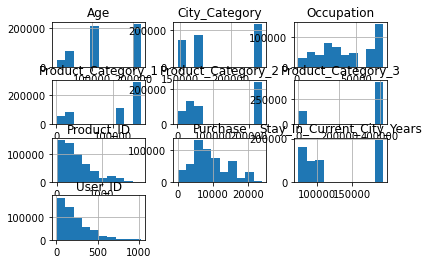

In [62]:
steps = [('scale',MinMaxScaler()),('p',PowerTransformer())]
pipe = Pipeline(steps)
Xdf = pipe.fit_transform(tempdf)
tempdf.hist()

In [46]:
MinMaxScaler?

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=30)
xgb_regressor = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.1)
xgb_regressor.fit(X_train,y_train)
y_pred = xgb_regressor.predict(X_test)
print('root_mean_squre_error : ',np.sqrt(mean_squared_error(y_test,y_pred)))
#root_mean_squre_error :  2553.094055599186
#our first model is encouraging.

NameError: name 'X' is not defined

In [22]:
#feature engineering
#Here we don't see any use of User_ID. lets try without User_ID
df_model = df_preprocess.copy()
X,y = df_model.iloc[:,1:-1].values , df_model.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=30)
xgb_regressor = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.1)
xgb_regressor.fit(X_train,y_train)
y_pred = xgb_regressor.predict(X_test)
print('root_mean_squre_error : ',np.sqrt(mean_squared_error(y_test,y_pred)))
#root_mean_squre_error :  2628.702061747934

root_mean_squre_error :  2673.049855636165


In [116]:
#XGboost can handle missing valuse. lets try with out imputing the vlaues
X,y = df_model.iloc[:,:-1].values , df_model.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=30)
xgb_regressor = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.1)
xgb_regressor.fit(X_train,y_train)
y_pred = xgb_regressor.predict(X_test)
print('root_mean_squre_error : ',np.sqrt(mean_squared_error(y_test,y_pred)))
#root_mean_squre_error :  2629.7723617066013

root_mean_squre_error :  2629.7723617066013


In [125]:
# we have many missing values in Product_Category_2 and Product_Category_3. So take a Z-test with Purchase and see if we can
# get ride of them
# next hyperparam tuning


In [ ]:
# next hyperparam tuning
xgb_regressor = xgb.XGBRegressor(n_jobs=2)
pipe = Pipeline(steps=[('regressor', xgb_regressor)])
            
params_grid ={'regressor__learning_rate':[0.1,0.5,0.1],
              'regressor__min_child_weight': [1, 5, 10],
              'regressor__gamma': [0.5, 1, 1.5, 2, 5],
              'regressor__subsample': [0.6, 0.8, 1.0],
              'regressor__colsample_bytree': [0.6, 0.8, 1.0],
              'regressor__max_depth': [3, 4, 5]}
cvrange = np.arange(4,11)
with(tqdm(len(cvrange))) as pbar:
    for cv in cvrange:
        gb = RandomizedSearchCV(estimator=pipe, cv=cv,param_distributions=params_grid,scoring='neg_root_mean_squared_error')
        gb.fit(X_train,y_train)
        score = gb.score(X_test,y_test)
        print('score : {}, cv : {}, best_score : {}, best_params = {}'.format(score,cv,gb.best_score_,[(k,v) for (k,v) in gb.best_params_.items()]))
        pbar.update()


0it [00:00, ?it/s]

In [9]:
#feature selection through ANOVA test for features with more than 2 classes otherwise Z-test
